### Purpose of this script

We'll do some analysis on the COVID tweets that we've scraped, from March 2020 to early January 2021. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
import wordcloud
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import textblob
from textblob import TextBlob
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import transformers
from transformers import pipeline
import torch
from pprint import pprint
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pd.set_option('display.max_columns', None) # show all columns

/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(
/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Counter, Iterable


In [2]:
IMPORT_DIR = "../../data/tweets/"

In [3]:
IMAGES_DIR = "../../media/images/"

In [20]:
tweets = pd.read_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_with_locations.csv")

/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Remove rows with NaNs, as well as duplicate rows

In [5]:
tweets = tweets.dropna(axis=0, subset=["cleaned_text", "cleaned_text_no_hashtags"])

In [6]:
tweets.drop_duplicates(inplace=True)

Change representation of dtypes in columns (to represent lists as lists, rather than strings)

In [7]:
tweets["cleaned_text"] = tweets["cleaned_text"].apply(lambda x : ast.literal_eval(x))

In [8]:
tweets["hashtags"] = tweets["hashtags"].apply(lambda x : ast.literal_eval(x))

In [9]:
tweets["cleaned_text_no_hashtags"] = tweets["cleaned_text_no_hashtags"].apply(lambda x : ast.literal_eval(x))

Get year of tweet (since we now have 2021 tweets)

In [124]:
tweets["year_of_tweet"] = tweets["date_of_tweet"].apply(lambda x : x.split('-')[0])

In [135]:
tweets["year_month_tweet"] = tweets["year_of_tweet"] + "-" + str(tweets["month_of_tweet"])

In [145]:
str(int(tweets["month_of_tweet"][0]))

'3'

In [153]:
tweets["year_month_tweet"] = ""

In [154]:
tweet_year_list = list(tweets["year_of_tweet"])
tweet_month_list = list(tweets["month_of_tweet"])

In [155]:
for idx in range(tweets.shape[0]):
    
    year = tweet_year_list[idx]
    month_int = int(tweet_month_list[idx])
    month = ""
    if month_int >= 10:
        month = str(month_int)
    else:
        month = '0' + str(month_int)
    
    year_month = year + '-' + month
    
    tweets["year_month_tweet"][idx] = year_month

<ipython-input-155-562d77aa17e7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["year_month_tweet"][idx] = year_month


Let's export this newly modified CSV file (preprocessing should've been done in a separate script, oops)

In [157]:
#tweets.to_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_cleaned_with_locations.csv")

### Preliminary Analysis

1. How many tweets do we have per state?

In [28]:
tweets["US_state"].value_counts()

CA             23347
NY             20843
USA            12535
TX              7910
FL              7811
               ...  
Milwaukee          1
San Diego          1
Huffman            1
Chicago            1
San Antonio        1
Name: US_state, Length: 82, dtype: int64

### Analysis of Hashtags

How many hashtags do the tweets have?

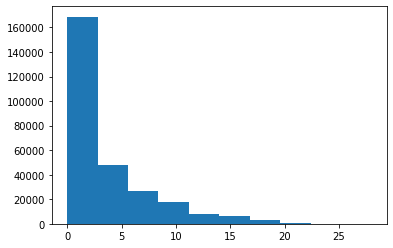

In [29]:
plt.hist(tweets["hashtags_count"])
plt.show()

In [30]:
tweets["hashtags_count"].describe()

count    278337.000000
mean          3.114440
std           4.302782
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max          28.000000
Name: hashtags_count, dtype: float64

What hashtags are most common?

In [31]:
all_hashtags = []

In [32]:
for lst in tweets["hashtags"]:
    try:
        if len(lst) > 0:
            for elem in lst:
                all_hashtags.append(elem)
    except Exception as e:
        continue

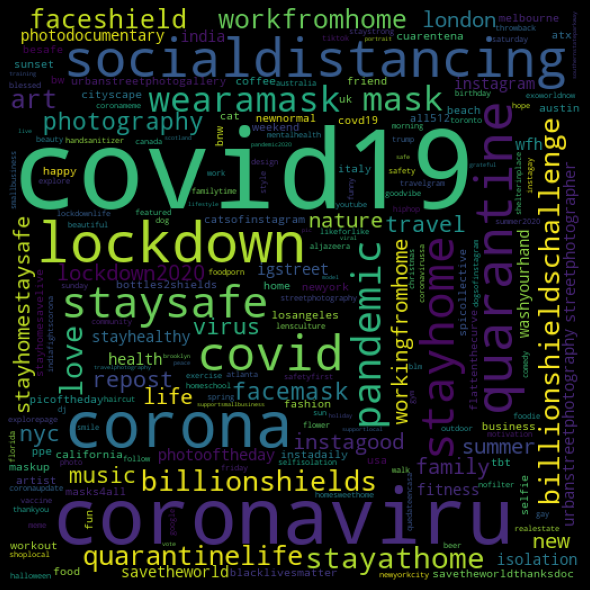

In [202]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(all_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-03-20-2021-01-09.png")
plt.show()

How does the distribution of hashtags vary across time?

In [54]:
march_hashtags = []
april_hashtags = []
may_hashtags = []
june_hashtags = []
july_hashtags = []
august_hashtags = []
september_hashtags = []
october_hashtags = []
november_hashtags = []
december_hashtags = []
january_hashtags = []

In [55]:
for month_num in [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    hashtag_subset = tweets[tweets["month_of_tweet"]==month_num]["hashtags"]
    hashtag_lst = []
    for lst in hashtag_subset:
        try:
            if len(lst) > 0:
                for elem in lst:
                    hashtag_lst.append(elem)
        except Exception as e:
            continue

    if month_num == 1:
        january_hashtags = hashtag_lst
    elif month_num == 3:
        march_hashtags = hashtag_lst
    elif month_num == 4:
        april_hashtags = hashtag_lst
    elif month_num == 5:
        may_hashtags = hashtag_lst
    elif month_num == 6:
        june_hashtags = hashtag_lst
    elif month_num == 7:
        july_hashtags = hashtag_lst
    elif month_num == 8:
        august_hashtags = hashtag_lst
    elif month_num == 9:
        september_hashtags = hashtag_lst
    elif month_num == 10:
        october_hashtags = hashtag_lst
    elif month_num == 11:
        november_hashtags = hashtag_lst
    elif month_num == 12:
        december_hashtags = hashtag_lst

Now let's do the hashtags per month

#### March 2020

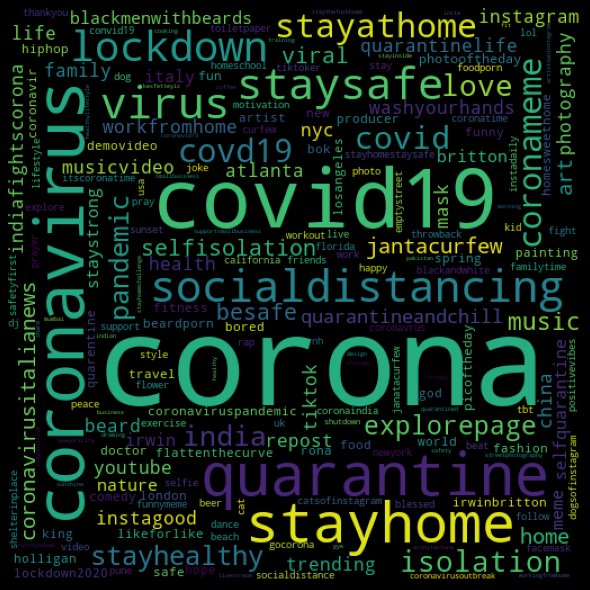

In [94]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(march_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-03.png")
plt.show()

#### April 2020

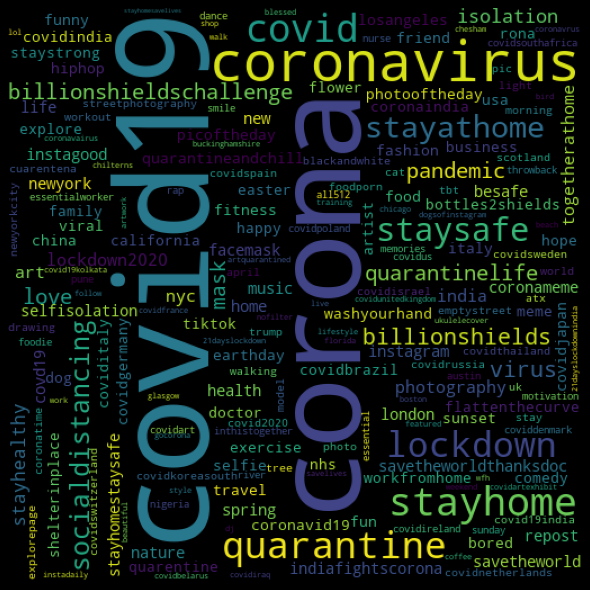

In [95]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(april_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-04.png")
plt.show()

#### May 2020

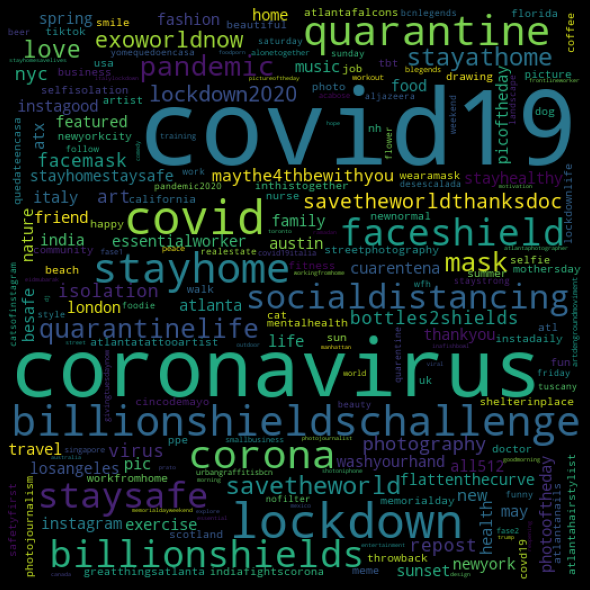

In [96]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(may_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-05.png")
plt.show()

#### June 2020

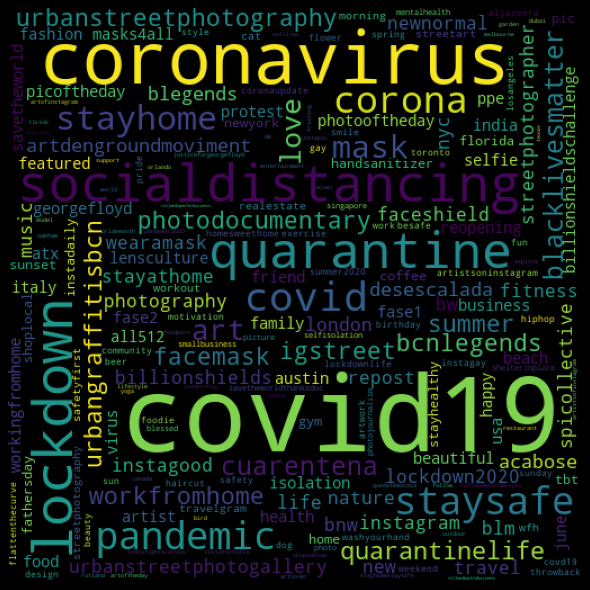

In [97]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(june_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-06.png")
plt.show()

#### July 2020

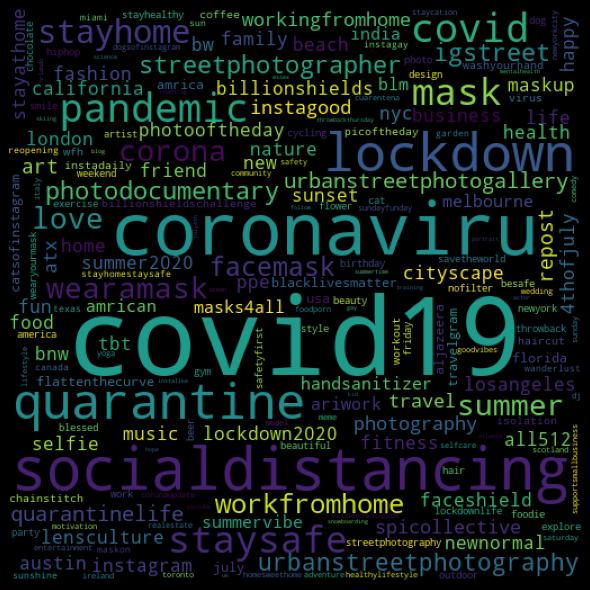

In [98]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(july_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-07.png")
plt.show()

#### August 2020

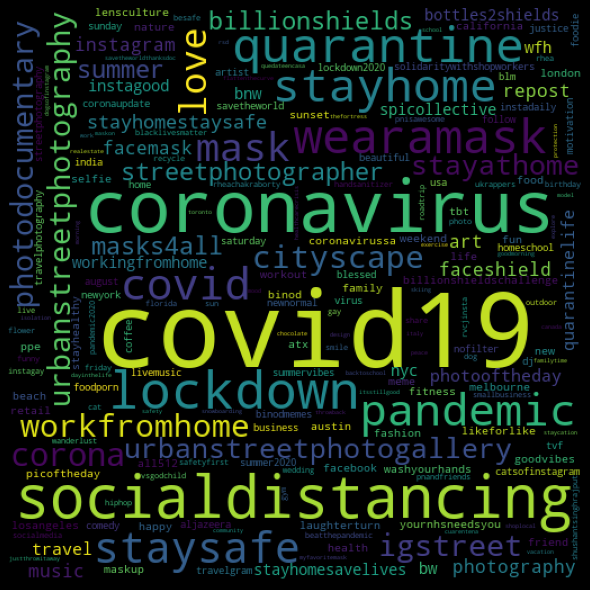

In [99]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(august_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-08.png")
plt.show()

#### September 2020

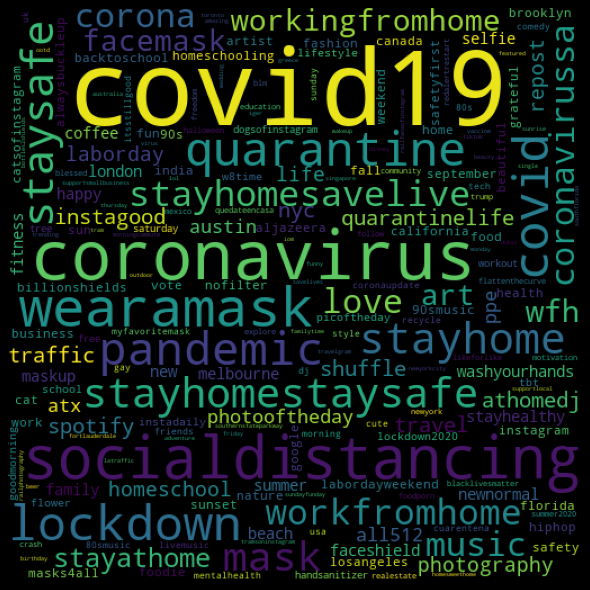

In [100]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(september_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-09.png")
plt.show()

#### October 2020

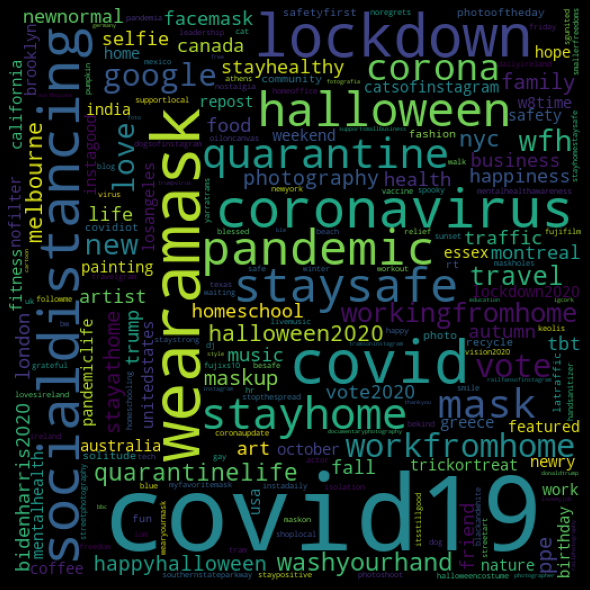

In [101]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(october_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-10.png")
plt.show()

#### November 2020

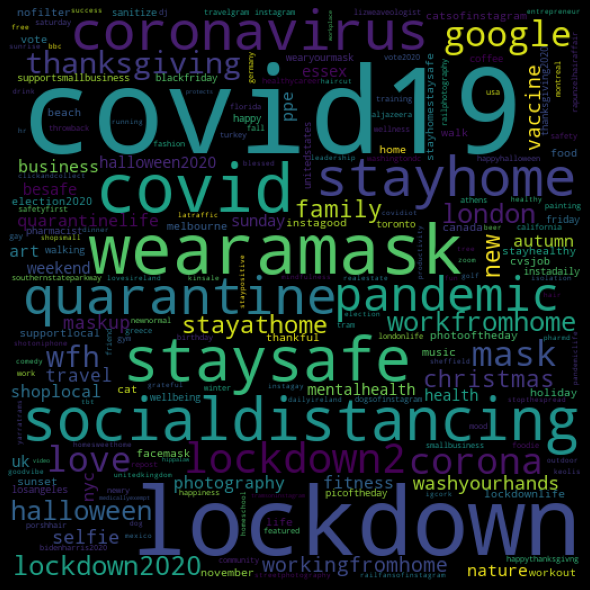

In [102]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(november_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-11.png")
plt.show()

#### December 2020

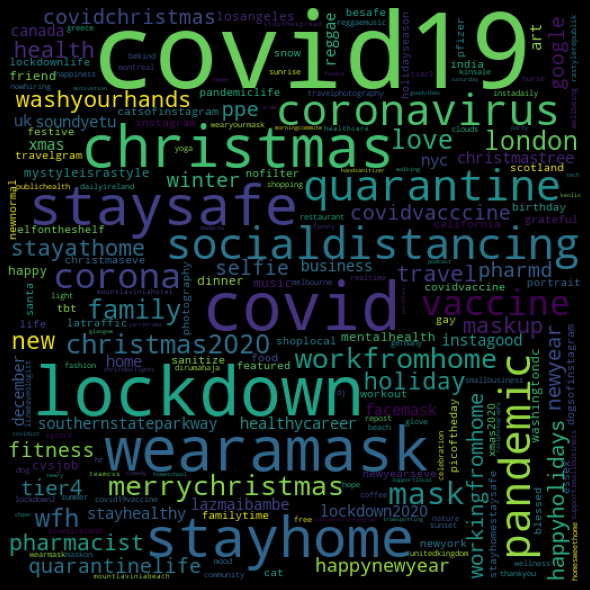

In [103]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(december_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2020-12.png")
plt.show()

#### January 2021

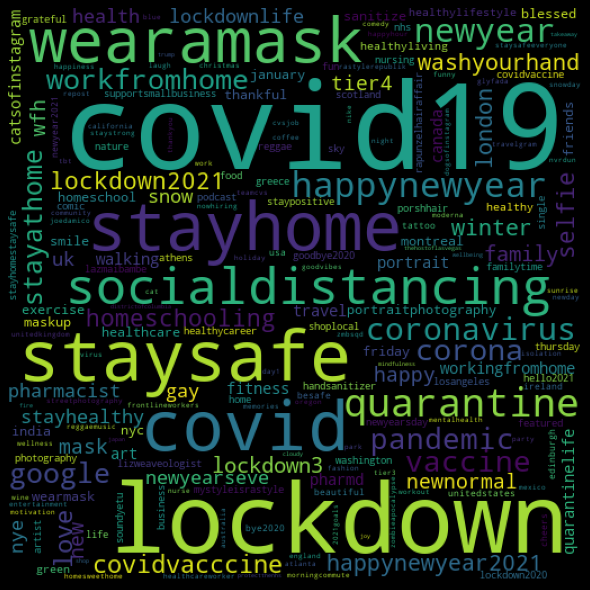

In [104]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(january_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig(IMAGES_DIR + "covid_wordCloud_2021-01.png")
plt.show()

### Topic Modelling

In [73]:
MODEL_DIR = "../../models/topic_models/"

In [72]:
os.listdir(MODEL_DIR)

[]

In [67]:
# create dictionary, corpus for mental health tweets
dict_covid = corpora.Dictionary(tweets["cleaned_text"])
corpus_covid = [dict_covid.doc2bow(tweet) for tweet in tweets["cleaned_text"]]

In [77]:
# dump files
pickle.dump(corpus_covid, open(MODEL_DIR + 'corpus_covid_2020-03-20_2021-01-09.pkl', 'wb'))
dict_covid.save(MODEL_DIR + 'dictionary_covid_2020-03-20_2021-01-09.gensim')

In [79]:
# do LDA (try 12 topics)
NUM_TOPICS = 12
ldamodel_covid = gensim.models.ldamodel.LdaModel(corpus_covid,
                                                 num_topics = NUM_TOPICS, 
                                                 id2word=dict_covid, 
                                                 passes=15)

In [80]:
# save lda model
ldamodel_covid.save('lda_model_covid_2020-03-20_2021-01-09.gensim')

In [81]:
topics = ldamodel_covid.print_topics(num_words=10)
for topic in topics:
    pprint(topic)

(0,
 '0.067*"stigma" + 0.066*"health" + 0.060*"fighting" + 0.058*"covid19" + '
 '0.017*"uk" + 0.014*"test" + 0.013*"coronavirus" + 0.011*"minister" + '
 '0.011*"hospital" + 0.011*"vaccines"')
(1,
 '0.022*"face" + 0.015*"georgia" + 0.014*"north" + 0.011*"eve" + 0.010*"amid" '
 '+ 0.009*"atlanta" + 0.009*"cold" + 0.009*"grateful" + 0.009*"carolina" + '
 '0.009*"church"')
(2,
 '0.037*"ontario" + 0.029*"center" + 0.017*"#covid19" + 0.015*"toronto" + '
 '0.011*"#maskup" + 0.011*"hill" + 0.010*"canada" + 0.010*"ni" + '
 '0.009*"#lockdown2020" + 0.009*"staying"')
(3,
 '0.056*"ireland" + 0.038*"cases" + 0.037*"new" + 0.029*"coronavirus" + '
 '0.023*"covid19" + 0.022*"northern" + 0.015*"deaths" + 0.012*"article" + '
 '0.011*"county" + 0.010*"corona"')
(4,
 '0.064*"#covid19" + 0.042*"#lockdown" + 0.029*"#covid" + 0.026*"#wearamask" + '
 '0.022*"#staysafe" + 0.021*"#socialdistancing" + 0.021*"#stayhome" + '
 '0.018*"#quarantine" + 0.017*"#coronavirus" + 0.015*"#pandemic"')
(5,
 '0.141*"covid" + 0

In [82]:
lda_display = pyLDAvis.gensim.prepare(ldamodel_covid, 
                                      corpus_covid, 
                                      dict_covid, sort_topics=False)
pyLDAvis.display(lda_display)

Let's see how well our topic modelling performs, using model perplexity and topic coherence.

See this tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [83]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_covid.log_perplexity(corpus_covid))  # a measure of how good the model is. lower the better.


Perplexity:  -12.725376575729625


In [84]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel_covid, texts=tweets["cleaned_text"], dictionary=dict_covid, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.356042154129079


Now, each document/tweet is a collection of topics, but can we figure out the predominant topic for a given tweet?

In [85]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [86]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_covid, corpus=corpus_covid, texts=tweets["cleaned_text"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-86-b215a164d762>", line 1, in <module>
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_covid, corpus=corpus_covid, texts=tweets["cleaned_text"])
  File "<ipython-input-85-d5f063bb4355>", line 11, in format_topics_sentences
    wp = ldamodel.show_topic(topic_num)
  File "/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/gensim/models/ldamodel.py", line 1192, in show_topic
    return [(self.id2word[id], value) for id, value in self.get_topic_terms(topicid, topn)]
  File "/Users/mark/opt/anaconda3/envs/twitter_venv/lib/python3.8/site-packages/gensim/models/ldamodel.py", line 1226, in get_topic_terms
    bestn = matutils.argsort(topic, topn, reverse=True)
  File "/Users/mark/opt/anaconda3/envs/twitt

TypeError: object of type 'NoneType' has no len()

Now, for each tweet, we have an assigned "topic". Let's add these to each tweet as our "labels"

In [ ]:
tweets["dominant_topic_label"] = df_dominant_topic["Dominant_Topic"]
tweets["dominant_topic_keywords"] = df_dominant_topic["Keywords"]

Is there a difference in topic distribution across months?

In [ ]:
pd.crosstab(tweets["month_of_tweet"], tweets["dominant_topic_label"], margins = True, normalize = "index")

Seems like there is some difference in the distribution of topics across time

Now, let's see if there's a difference in the distribution of topics across locations (limiting our search to "CA", "NY", "TX", and "FL")

In [ ]:
bool_state_arr = []

In [ ]:
for state in tweets["US_state"]:
    if state in ["NY", "CA", "FL", "TX"]:
        bool_state_arr.append(True)
    else:
        bool_state_arr.append(False)

In [ ]:
tweets_filtered = tweets[bool_state_arr]

In [ ]:
pd.crosstab(tweets_filtered["US_state"], tweets_filtered["dominant_topic_label"], margins = True, normalize = "index")

### How do certain keywords trend?

In [105]:
tweets.head()

Unnamed: 0                   id  \
0          0  1240728065983959040   
1          1  1240728187136610306   
2          2  1240728221986906113   
3          3  1240728361556750338   
4          4  1240728639358017536   

                                           full_text retweet_count  \
0  #statewaterheaters #getitin #corona #keepingpe...             0   
1  "ain't no humans outside! (corona!)" 😂😂😂🤣 @ Cl...             0   
2  Salam Friends\nLooking at the grave financial ...             0   
3  Thanks to COVID19 we are under unprecedented l...             0   
4  #tbt to the current #anime that I'm rewatching...             0   

   favorite_count                                              place US_state  \
0             1.0  {'id': '3995cc1483801d24', 'url': 'https://api...       OH   
1             0.0  {'id': '0eb9676d24b211f1', 'url': 'https://api...       OH   
2             0.0  {'id': '01aadce76841e2c5', 'url': 'https://api...      NaN   
3             0.0  {'id': '7db53e74bdc6007e', 'url': 'https://api...      NaN   
4             0.0  {'id': '00893962665a2284', 'url': 'https://api...      NaN   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-03-19             3.0           19            19   
1    2020-03-19             3.0           19            19   
2    2020-03-19             3.0           19            19   
3    2020-03-19             3.0           19            19   
4    2020-03-19             3.0           19            19   

                                        cleaned_text  \
0  [#statewaterheaters, #getitin, #corona, #keepi...   
1   [aint, humans, outside, corona, cleveland, ohio]   
2  [salam, friends, looking, grave, financial, si...   
3  [thanks, covid19, unprecedented, levels, stres...   
4  [#tbt, current, #anime, im, rewatching, #coron...   

                                            hashtags  hashtags_count  \
0  [#statewaterheaters, #getitin, #corona, #keepi...             6.0   
1                                                 []             0.0   
2                                                 []             0.0   
3                                                 []             0.0   
4  [#tbt, #anime, #corona, #codegeass, #lelouchof...             8.0   

                            cleaned_text_no_hashtags  
0     [new, water, heater, swap, pickerington, ohio]  
1   [aint, humans, outside, corona, cleveland, ohio]  
2  [salam, friends, looking, grave, financial, si...  
3  [thanks, covid19, unprecedented, levels, stres...  
4  [current, im, rewatching, threat, keeping, us,...

#covid

In [111]:
has_covid = ["covid" in txt or "#covid" in txt for txt in tweets["cleaned_text"]]

In [158]:
covid_tweets = tweets[has_covid]

In [169]:
counts_covid_tweets = covid_tweets["year_month_tweet"].value_counts().sort_index()

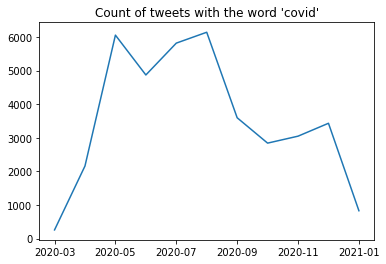

In [172]:
counts_covid_tweets.plot()
plt.title(f"Count of tweets with the word 'covid'")
plt.show()

#covid19

In [106]:
has_covid19 = ["covid19" in txt or "#covid19" in txt for txt in tweets["cleaned_text"]]

In [159]:
covid19_tweets = tweets[has_covid19]

In [173]:
counts_covid19_tweets = covid19_tweets["year_month_tweet"].value_counts().sort_index()

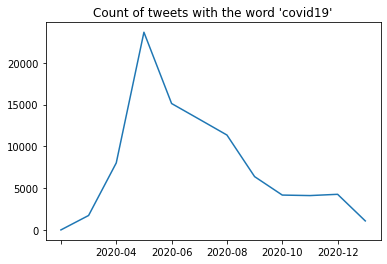

In [175]:
counts_covid19_tweets.plot()
plt.title(f"Count of tweets with the word 'covid19'")
plt.show()

#lockdown

In [117]:
has_lockdown = ["lockdown" in txt or "#lockdown" in txt for txt in tweets["cleaned_text"]]

In [160]:
lockdown_tweets = tweets[has_lockdown]

In [176]:
counts_lockdown_tweets = lockdown_tweets["year_month_tweet"].value_counts().sort_index()

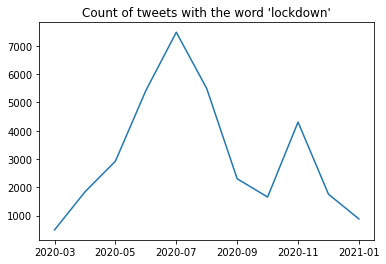

In [177]:
counts_lockdown_tweets.plot()
plt.title(f"Count of tweets with the word 'lockdown'")
plt.show()

#newnormal

In [118]:
has_newnormal = ["newnormal" in txt or "#newnormal" in txt for txt in tweets["cleaned_text"]]

In [161]:
newnormal_tweets = tweets[has_newnormal]

In [178]:
counts_newnormal_tweets = newnormal_tweets["year_month_tweet"].value_counts().sort_index()

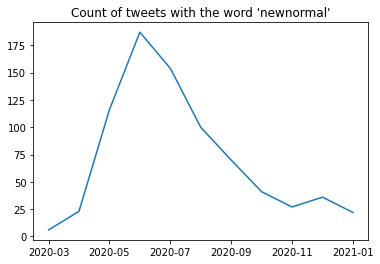

In [179]:
counts_newnormal_tweets.plot()
plt.title(f"Count of tweets with the word 'newnormal'")
plt.show()

#vaccine

In [119]:
has_vaccine = ["vaccine" in txt or "#vaccine" in txt for txt in tweets["cleaned_text"]]

In [181]:
vaccine_tweets = tweets[has_vaccine]

In [182]:
counts_vaccine_tweets = vaccine_tweets["year_month_tweet"].value_counts().sort_index()

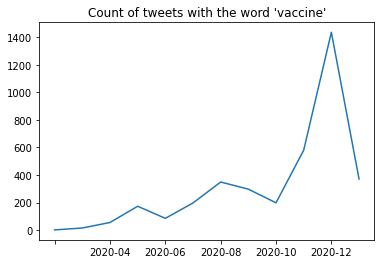

In [183]:
counts_vaccine_tweets.plot()
plt.title(f"Count of tweets with the word 'vaccine'")
plt.show()

In [191]:
tweet_counts_by_word = pd.concat([counts_covid_tweets, counts_covid19_tweets, counts_lockdown_tweets, 
                                     counts_newnormal_tweets, counts_vaccine_tweets], axis=1)

tweet_counts_by_word.columns = ["covid", "covid19", "lockdown", "newnormal", "vaccine"]

In [204]:
normalized_counts_covid_tweets = counts_covid_tweets / sum(counts_covid_tweets)
normalized_counts_covid19_tweets = counts_covid19_tweets / sum(counts_covid19_tweets)
normalized_counts_lockdown_tweets = counts_lockdown_tweets / sum(counts_lockdown_tweets)
normalized_counts_newnormal_tweets = counts_newnormal_tweets / sum(counts_newnormal_tweets)
normalized_counts_vaccine_tweets = counts_vaccine_tweets / sum(counts_vaccine_tweets)

In [194]:
#tweet_counts_by_word.drop(index='', axis=0, inplace=True)

In [195]:
tweet_counts_by_word

covid  covid19  lockdown  newnormal  vaccine
2020-03   256.0     1729     491.0        6.0       15
2020-04  2159.0     8020    1838.0       23.0       55
2020-05  6055.0    23658    2923.0      116.0      173
2020-06  4869.0    15128    5422.0      187.0       85
2020-07  5817.0    13248    7485.0      154.0      197
2020-08  6141.0    11357    5493.0      100.0      349
2020-09  3595.0     6380    2301.0       70.0      297
2020-10  2840.0     4172    1655.0       41.0      198
2020-11  3047.0     4112    4306.0       27.0      580
2020-12  3431.0     4264    1755.0       36.0     1437
2021-01   827.0     1079     879.0       22.0      371

In [205]:
tweet_counts_by_word_normalized = pd.concat([normalized_counts_covid_tweets, normalized_counts_covid19_tweets, 
                                             normalized_counts_lockdown_tweets, normalized_counts_newnormal_tweets, 
                                             normalized_counts_vaccine_tweets], axis=1)

tweet_counts_by_word_normalized.columns = ["covid", "covid19", "lockdown", "newnormal", "vaccine"]

In [210]:
#tweet_counts_by_word_normalized.drop(index='', axis=0, inplace=True)
tweet_counts_by_word_normalized

covid   covid19  lockdown  newnormal   vaccine
2020-03  0.006558  0.018562  0.014212   0.007673  0.003991
2020-04  0.055307  0.086099  0.053201   0.029412  0.014635
2020-05  0.155109  0.253980  0.084607   0.148338  0.046035
2020-06  0.124728  0.162406  0.156941   0.239130  0.022618
2020-07  0.149012  0.142224  0.216655   0.196931  0.052422
2020-08  0.157312  0.121923  0.158996   0.127877  0.092869
2020-09  0.092092  0.068492  0.066603   0.089514  0.079031
2020-10  0.072751  0.044788  0.047904   0.052430  0.052688
2020-11  0.078054  0.044144  0.124638   0.034527  0.154337
2020-12  0.087891  0.045776  0.050799   0.046036  0.382384
2021-01  0.021185  0.011584  0.025443   0.028133  0.098723

In [199]:
IMAGES_DIR

'../../media/images/'

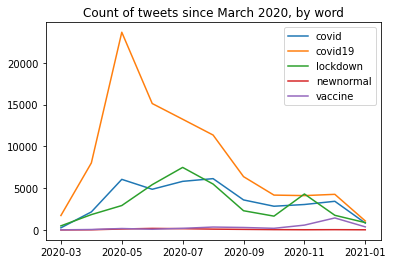

In [200]:
tweet_counts_by_word.plot()
plt.title(f"Count of tweets since March 2020, by word")
plt.savefig(IMAGES_DIR + "tweet_counts_by_word_2020-03-20_2021-01-09.png")
plt.show()

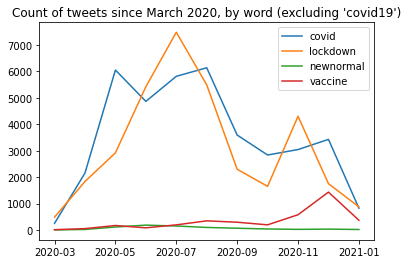

In [201]:
tweet_counts_by_word.drop(['covid19'], axis=1).plot()
plt.title(f"Count of tweets since March 2020, by word (excluding 'covid19')")
plt.savefig(IMAGES_DIR + "tweet_counts_by_word_excludeCovid19_2020-03-20_2021-01-09.png")
plt.show()

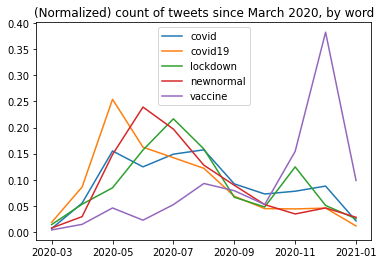

In [212]:
tweet_counts_by_word_normalized.plot()
plt.title(f"(Normalized) count of tweets since March 2020, by word")
plt.savefig(IMAGES_DIR + "normalized_tweet_counts_by_word_2020-03-20_2021-01-09.png")
plt.show()

### How many tweets were US vs. non-US tweets?

In [217]:
tweets["US_state"].head()

0     OH
1     OH
2    NaN
3    NaN
4    NaN
Name: US_state, dtype: object

In [236]:
tweets["is_US"] = tweets["US_state"].notnull()

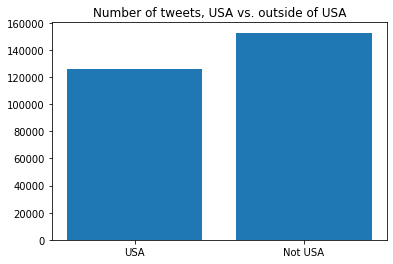

In [241]:
plt.bar(x=["USA", "Not USA"], height=tweets["is_US"].value_counts().sort_values())
plt.title("Number of tweets, USA vs. outside of USA")
plt.savefig(IMAGES_DIR + "count_tweets_USA_notUSA.png")
plt.show()

### What is the distribution of USA tweets, by state?

In [233]:
tweets.head()

Unnamed: 0                   id  \
0          0  1240728065983959040   
1          1  1240728187136610306   
2          2  1240728221986906113   
3          3  1240728361556750338   
4          4  1240728639358017536   

                                           full_text retweet_count  \
0  #statewaterheaters #getitin #corona #keepingpe...             0   
1  "ain't no humans outside! (corona!)" 😂😂😂🤣 @ Cl...             0   
2  Salam Friends\nLooking at the grave financial ...             0   
3  Thanks to COVID19 we are under unprecedented l...             0   
4  #tbt to the current #anime that I'm rewatching...             0   

   favorite_count                                              place US_state  \
0             1.0  {'id': '3995cc1483801d24', 'url': 'https://api...       OH   
1             0.0  {'id': '0eb9676d24b211f1', 'url': 'https://api...       OH   
2             0.0  {'id': '01aadce76841e2c5', 'url': 'https://api...      NaN   
3             0.0  {'id': '7db53e74bdc6007e', 'url': 'https://api...      NaN   
4             0.0  {'id': '00893962665a2284', 'url': 'https://api...      NaN   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-03-19             3.0           19            19   
1    2020-03-19             3.0           19            19   
2    2020-03-19             3.0           19            19   
3    2020-03-19             3.0           19            19   
4    2020-03-19             3.0           19            19   

                                        cleaned_text  \
0  [#statewaterheaters, #getitin, #corona, #keepi...   
1   [aint, humans, outside, corona, cleveland, ohio]   
2  [salam, friends, looking, grave, financial, si...   
3  [thanks, covid19, unprecedented, levels, stres...   
4  [#tbt, current, #anime, im, rewatching, #coron...   

                                            hashtags  hashtags_count  \
0  [#statewaterheaters, #getitin, #corona, #keepi...             6.0   
1                                                 []             0.0   
2                                                 []             0.0   
3                                                 []             0.0   
4  [#tbt, #anime, #corona, #codegeass, #lelouchof...             8.0   

                            cleaned_text_no_hashtags year_of_tweet  \
0     [new, water, heater, swap, pickerington, ohio]          2020   
1   [aint, humans, outside, corona, cleveland, ohio]          2020   
2  [salam, friends, looking, grave, financial, si...          2020   
3  [thanks, covid19, unprecedented, levels, stres...          2020   
4  [current, im, rewatching, threat, keeping, us,...          2020   

  year_month_tweet  is_US  
0          2020-03  False  
1          2020-03  False  
2          2020-03   True  
3          2020-03   True  
4          2020-03   True

In [243]:
US_tweets = tweets[tweets["is_US"] == True]

In [246]:
US_states_count_top20 = US_tweets["US_state"].value_counts().head(20)

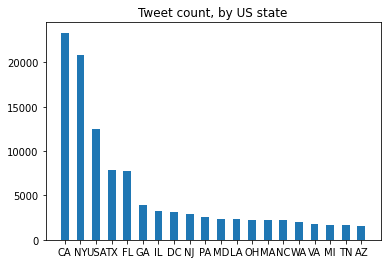

In [261]:
plt.bar(x=US_states_count_top20.index, height=US_states_count_top20, width=0.5)
plt.title("Tweet count, by US state")
plt.show()

### Perform sentiment analysis on the tweets

We'll perform sentiment analysis on the tweets. We'll use several ways to try and accomplish this:

1. Pre-trained VADER models
2. Textblob
3. HuggingFace pre-trained models


#### VADER Model

VADER is a rule-based sentiment analysis model that is popular for social media sentiment analysis. 

Useful guide: https://predictivehacks.com/how-to-run-sentiment-analysis-in-python-using-vader/

The VADER library returns 4 values:
1. `pos`: the probability of the sentiment being positive
2. `neu`: the probability of the sentiment being neutral
3. `neg`: the probability of the sentiment being negative
4. `compound`: the normalized "single metric" of sentiment (score >= 0.5 --> positive, -0.05 < score < 0.05 --> neutral, score <-0.05 --> negative)

In [264]:
#nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mark/nltk_data...


True

In [265]:
analyzer = SentimentIntensityAnalyzer()

Let's use a sample tweet:

In [266]:
" ".join(tweets["cleaned_text_no_hashtags"][0])

'new water heater swap pickerington ohio'

In [267]:
analyzer.polarity_scores(" ".join(tweets["cleaned_text_no_hashtags"][0]))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [271]:
output_dict = analyzer.polarity_scores(" ".join(tweets["cleaned_text_no_hashtags"][0]))

In [272]:
output_dict['neg']

0.0

In [274]:
pos_scores = []
neu_scores = []
neg_scores = []
compound_scores = []

In [275]:
for idx, tokenized_text in enumerate(list(tweets["cleaned_text_no_hashtags"])):
    
    if idx % 1000 == 0:
        print(f"Finished with tweet {idx} out of {tweets.shape[0]}")
        
    combined_text = " ".join(tokenized_text)
    
    output_dict = analyzer.polarity_scores(combined_text)

    pos_scores.append(output_dict["pos"])
    neu_scores.append(output_dict["neu"])
    neg_scores.append(output_dict["neg"])
    compound_scores.append(output_dict["compound"])
    
    if idx <= 5:
        print(f"Here's an example tweet: {combined_text}")
        print(f"Here are the scores that it got: {output_dict}")
    
    
    

Finished with tweet 0 out of 278337
Here's an example tweet: new water heater swap pickerington ohio
Here are the scores that it got: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Here's an example tweet: aint humans outside corona cleveland ohio
Here are the scores that it got: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Here's an example tweet: salam friends looking grave financial situation middle amp lower class household karachi developed due corona threat planning take initiative ideas required
Here are the scores that it got: {'neg': 0.29, 'neu': 0.601, 'pos': 0.11, 'compound': -0.6249}
Here's an example tweet: thanks covid19 unprecedented levels stress thanks corona seanie denied boarding paris heading abidjan 10week contract unexpectedly
Here are the scores that it got: {'neg': 0.243, 'neu': 0.511, 'pos': 0.247, 'compound': 0.0258}
Here's an example tweet: current im rewatching threat keeping us home netflix africa
Here are the scores that it got: {'neg': 0.2

Finished with tweet 173000 out of 278337
Finished with tweet 174000 out of 278337
Finished with tweet 175000 out of 278337
Finished with tweet 176000 out of 278337
Finished with tweet 177000 out of 278337
Finished with tweet 178000 out of 278337
Finished with tweet 179000 out of 278337
Finished with tweet 180000 out of 278337
Finished with tweet 181000 out of 278337
Finished with tweet 182000 out of 278337
Finished with tweet 183000 out of 278337
Finished with tweet 184000 out of 278337
Finished with tweet 185000 out of 278337
Finished with tweet 186000 out of 278337
Finished with tweet 187000 out of 278337
Finished with tweet 188000 out of 278337
Finished with tweet 189000 out of 278337
Finished with tweet 190000 out of 278337
Finished with tweet 191000 out of 278337
Finished with tweet 192000 out of 278337
Finished with tweet 193000 out of 278337
Finished with tweet 194000 out of 278337
Finished with tweet 195000 out of 278337
Finished with tweet 196000 out of 278337
Finished with tw

Let's add these columns to our dataset

In [290]:
tweets["vader_pos_score"] = pos_scores
tweets["vader_neu_score"] = neu_scores
tweets["vader_neg_score"] = neg_scores
tweets["vader_compound_score"] = compound_scores

#### TextBlob Sentiment Analysis

Useful resources for TextBlob:

1. https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
2. https://stackabuse.com/sentiment-analysis-in-python-with-textblob/



Example

In [281]:
sentence = TextBlob(" ".join(tweets["cleaned_text_no_hashtags"][1]))

In [282]:
sentence.sentiment

Sentiment(polarity=0.0, subjectivity=0.05)

Now, doing it on  all the tweets:

In [283]:
polarity_scores = []
subjectivity_scores = []

In [284]:
for idx, tokenized_text in enumerate(list(tweets["cleaned_text_no_hashtags"])):
    
    if idx % 1000 == 0:
        print(f"Finished with tweet {idx} out of {tweets.shape[0]}")
        
    combined_text = " ".join(tokenized_text)
    
    sentence = TextBlob(combined_text)

    sentiment=sentence.sentiment
    
    polarity_scores.append(sentiment.polarity)
    subjectivity_scores.append(sentiment.subjectivity)
    
    
    if idx <= 5:
        print(f"Here's an example tweet: {combined_text}")
        print(f"Here are the scores that it got: {sentiment}")

Finished with tweet 0 out of 278337
Here's an example tweet: new water heater swap pickerington ohio
Here are the scores that it got: Sentiment(polarity=0.13636363636363635, subjectivity=0.45454545454545453)
Here's an example tweet: aint humans outside corona cleveland ohio
Here are the scores that it got: Sentiment(polarity=0.0, subjectivity=0.05)
Here's an example tweet: salam friends looking grave financial situation middle amp lower class household karachi developed due corona threat planning take initiative ideas required
Here are the scores that it got: Sentiment(polarity=-0.006249999999999999, subjectivity=0.16875)
Here's an example tweet: thanks covid19 unprecedented levels stress thanks corona seanie denied boarding paris heading abidjan 10week contract unexpectedly
Here are the scores that it got: Sentiment(polarity=0.275, subjectivity=0.575)
Here's an example tweet: current im rewatching threat keeping us home netflix africa
Here are the scores that it got: Sentiment(polarit

Finished with tweet 174000 out of 278337
Finished with tweet 175000 out of 278337
Finished with tweet 176000 out of 278337
Finished with tweet 177000 out of 278337
Finished with tweet 178000 out of 278337
Finished with tweet 179000 out of 278337
Finished with tweet 180000 out of 278337
Finished with tweet 181000 out of 278337
Finished with tweet 182000 out of 278337
Finished with tweet 183000 out of 278337
Finished with tweet 184000 out of 278337
Finished with tweet 185000 out of 278337
Finished with tweet 186000 out of 278337
Finished with tweet 187000 out of 278337
Finished with tweet 188000 out of 278337
Finished with tweet 189000 out of 278337
Finished with tweet 190000 out of 278337
Finished with tweet 191000 out of 278337
Finished with tweet 192000 out of 278337
Finished with tweet 193000 out of 278337
Finished with tweet 194000 out of 278337
Finished with tweet 195000 out of 278337
Finished with tweet 196000 out of 278337
Finished with tweet 197000 out of 278337
Finished with tw

Adding to our dataset:

In [291]:
tweets["textblob_polarity_scores"] = polarity_scores
tweets["textblob_subjectivity_scores"] = subjectivity_scores

In [295]:
#tweets.to_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_with_sentiment_2021-01-12.csv")

### DistilBERT

We'll be using DistilBERT, a condensed, smaller, faster version of BERT (trained on the losses of the original BERT model). 

It takes the original DistilBERT model and fine-tunes it on the SST-2 dataset.

Here's the HuggingFace link to their implementation: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

I'll be basing the code off this resource: https://www.machinecurve.com/index.php/2020/12/23/easy-sentiment-analysis-with-machine-learning-and-huggingface-transformers/

In [3]:
#tweets = pd.read_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_with_sentiment_2021-01-12.csv")

Preprocessing steps

In [4]:
tweets = tweets.dropna(axis=0, subset=["cleaned_text", "cleaned_text_no_hashtags"])
tweets.drop_duplicates(inplace=True)
tweets["cleaned_text"] = tweets["cleaned_text"].apply(lambda x : ast.literal_eval(x))
tweets["hashtags"] = tweets["hashtags"].apply(lambda x : ast.literal_eval(x))
tweets["cleaned_text_no_hashtags"] = tweets["cleaned_text_no_hashtags"].apply(lambda x : ast.literal_eval(x))

In [5]:
tweets["cleaned_text_joined"] = tweets["cleaned_text_no_hashtags"].apply(lambda x : " ".join(x))

Load pre-trained model from HuggingFace

In [6]:
sentiment_analyzer = pipeline("sentiment-analysis")

In [7]:
sentiment_analyzer(list(tweets["cleaned_text_joined"])[0])

[{'label': 'NEGATIVE', 'score': 0.9588645100593567}]

In [8]:
tweets["distilBERT_sentiment"] = ""

In [9]:
distilBERT_sentiments = []

In [10]:
for idx, tweet in enumerate(list(tweets["cleaned_text_joined"])):
    
    if idx % 1000 == 0:
        print(f"Getting the distilBERT sentiment for tweet {idx} out of {tweets.shape[0]}")
    
    distilBERT_sentiments.append(sentiment_analyzer(tweet))

Getting the distilBERT sentiment for tweet 0 out of 278337
Getting the distilBERT sentiment for tweet 1000 out of 278337
Getting the distilBERT sentiment for tweet 2000 out of 278337
Getting the distilBERT sentiment for tweet 3000 out of 278337
Getting the distilBERT sentiment for tweet 4000 out of 278337
Getting the distilBERT sentiment for tweet 5000 out of 278337
Getting the distilBERT sentiment for tweet 6000 out of 278337
Getting the distilBERT sentiment for tweet 7000 out of 278337
Getting the distilBERT sentiment for tweet 8000 out of 278337
Getting the distilBERT sentiment for tweet 9000 out of 278337
Getting the distilBERT sentiment for tweet 10000 out of 278337
Getting the distilBERT sentiment for tweet 11000 out of 278337
Getting the distilBERT sentiment for tweet 12000 out of 278337
Getting the distilBERT sentiment for tweet 13000 out of 278337
Getting the distilBERT sentiment for tweet 14000 out of 278337
Getting the distilBERT sentiment for tweet 15000 out of 278337
Getti

Getting the distilBERT sentiment for tweet 130000 out of 278337
Getting the distilBERT sentiment for tweet 131000 out of 278337
Getting the distilBERT sentiment for tweet 132000 out of 278337
Getting the distilBERT sentiment for tweet 133000 out of 278337
Getting the distilBERT sentiment for tweet 134000 out of 278337
Getting the distilBERT sentiment for tweet 135000 out of 278337
Getting the distilBERT sentiment for tweet 136000 out of 278337
Getting the distilBERT sentiment for tweet 137000 out of 278337
Getting the distilBERT sentiment for tweet 138000 out of 278337
Getting the distilBERT sentiment for tweet 139000 out of 278337
Getting the distilBERT sentiment for tweet 140000 out of 278337
Getting the distilBERT sentiment for tweet 141000 out of 278337
Getting the distilBERT sentiment for tweet 142000 out of 278337
Getting the distilBERT sentiment for tweet 143000 out of 278337
Getting the distilBERT sentiment for tweet 144000 out of 278337
Getting the distilBERT sentiment for twe

Getting the distilBERT sentiment for tweet 259000 out of 278337
Getting the distilBERT sentiment for tweet 260000 out of 278337
Getting the distilBERT sentiment for tweet 261000 out of 278337
Getting the distilBERT sentiment for tweet 262000 out of 278337
Getting the distilBERT sentiment for tweet 263000 out of 278337
Getting the distilBERT sentiment for tweet 264000 out of 278337
Getting the distilBERT sentiment for tweet 265000 out of 278337
Getting the distilBERT sentiment for tweet 266000 out of 278337
Getting the distilBERT sentiment for tweet 267000 out of 278337
Getting the distilBERT sentiment for tweet 268000 out of 278337
Getting the distilBERT sentiment for tweet 269000 out of 278337
Getting the distilBERT sentiment for tweet 270000 out of 278337
Getting the distilBERT sentiment for tweet 271000 out of 278337
Getting the distilBERT sentiment for tweet 272000 out of 278337
Getting the distilBERT sentiment for tweet 273000 out of 278337
Getting the distilBERT sentiment for twe

In [12]:
tweets["distilBERT_sentiment"] = distilBERT_sentiments

In [ ]:
%%time
#tweets["distilBERT_sentiment"] = sentiment_analyzer(list(tweets["cleaned_text_joined"]))

In [14]:
tweets.head()

Unnamed: 0  Unnamed: 0.1                   id  \
0           0             0  1240728065983959040   
1           1             1  1240728187136610306   
2           2             2  1240728221986906113   
3           3             3  1240728361556750338   
4           4             4  1240728639358017536   

                                           full_text  retweet_count  \
0  #statewaterheaters #getitin #corona #keepingpe...              0   
1  "ain't no humans outside! (corona!)" 😂😂😂🤣 @ Cl...              0   
2  Salam Friends\nLooking at the grave financial ...              0   
3  Thanks to COVID19 we are under unprecedented l...              0   
4  #tbt to the current #anime that I'm rewatching...              0   

   favorite_count                                              place US_state  \
0             1.0  {'id': '3995cc1483801d24', 'url': 'https://api...       OH   
1             0.0  {'id': '0eb9676d24b211f1', 'url': 'https://api...       OH   
2             0.0  {'id': '01aadce76841e2c5', 'url': 'https://api...      NaN   
3             0.0  {'id': '7db53e74bdc6007e', 'url': 'https://api...      NaN   
4             0.0  {'id': '00893962665a2284', 'url': 'https://api...      NaN   

  date_of_tweet  month_of_tweet  day_of_tweet  hour_of_tweet  \
0    2020-03-19             3.0            19             19   
1    2020-03-19             3.0            19             19   
2    2020-03-19             3.0            19             19   
3    2020-03-19             3.0            19             19   
4    2020-03-19             3.0            19             19   

                                        cleaned_text  \
0  [#statewaterheaters, #getitin, #corona, #keepi...   
1   [aint, humans, outside, corona, cleveland, ohio]   
2  [salam, friends, looking, grave, financial, si...   
3  [thanks, covid19, unprecedented, levels, stres...   
4  [#tbt, current, #anime, im, rewatching, #coron...   

                                            hashtags  hashtags_count  \
0  [#statewaterheaters, #getitin, #corona, #keepi...             6.0   
1                                                 []             0.0   
2                                                 []             0.0   
3                                                 []             0.0   
4  [#tbt, #anime, #corona, #codegeass, #lelouchof...             8.0   

                            cleaned_text_no_hashtags  year_of_tweet  \
0     [new, water, heater, swap, pickerington, ohio]           2020   
1   [aint, humans, outside, corona, cleveland, ohio]           2020   
2  [salam, friends, looking, grave, financial, si...           2020   
3  [thanks, covid19, unprecedented, levels, stres...           2020   
4  [current, im, rewatching, threat, keeping, us,...           2020   

  year_month_tweet  is_US  vader_pos_score  vader_neu_score  vader_neg_score  \
0          2020-03   True            0.000            1.000            0.000   
1          2020-03   True            0.000            1.000            0.000   
2          2020-03  False            0.110            0.601            0.290   
3          2020-03  False            0.247            0.511            0.243   
4          2020-03  False            0.000            0.702            0.298   

   vader_compound_score  textblob_polarity_scores  \
0                0.0000                  0.136364   
1                0.0000                  0.000000   
2               -0.6249                 -0.006250   
3                0.0258                  0.275000   
4               -0.5267                  0.000000   

   textblob_subjectivity_scores  \
0                      0.454545   
1                      0.050000   
2                      0.168750   
3                      0.575000   
4                      0.400000   

                                 cleaned_text_joined  \
0            new water heater swap pickerington ohio   
1          aint humans outside corona cleveland ohio   
2  salam friend

In [15]:
tweets["distilBERT_sentiment_label"] = [x[0]["label"] for x in tweets["distilBERT_sentiment"]]
tweets["distilBERT_sentiment_score"] = [x[0]["score"] for x in tweets["distilBERT_sentiment"]]

In [27]:
def adjusted_sentiment_label(x):

    if x > 0.6:
        return "POS"
    elif x < 0.4:
        return "NEG"
    else:
        return "NEU"

Add "NEUTRAL" tweets as well

In [37]:
tweets["distilBERT_adjusted_sentiment_label"] = [label if score > 0.8 else "NEUTRAL"  for label, score in zip(tweets["distilBERT_sentiment_label"], 
                                                                                                              tweets["distilBERT_sentiment_score"])]

In [38]:
tweets["distilBERT_adjusted_sentiment_label"].value_counts()

NEGATIVE    141730
POSITIVE    106512
NEUTRAL      30095
Name: distilBERT_adjusted_sentiment_label, dtype: int64

In [39]:
tweets.to_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_with_sentiment_2021-01-13.csv")

In [16]:
tweets

Unnamed: 0  Unnamed: 0.1                   id  \
0                0             0  1240728065983959040   
1                1             1  1240728187136610306   
2                2             2  1240728221986906113   
3                3             3  1240728361556750338   
4                4             4  1240728639358017536   
...            ...           ...                  ...   
278332      278336        278334  1347755687053586432   
278333      278337        278335  1347736739750711296   
278334      278338        278336  1347734941648515072   
278335      278339        278337  1347747667279941633   
278336      278340        278338  1347756622702129152   

                                                full_text  retweet_count  \
0       #statewaterheaters #getitin #corona #keepingpe...              0   
1       "ain't no humans outside! (corona!)" 😂😂😂🤣 @ Cl...              0   
2       Salam Friends\nLooking at the grave financial ...              0   
3       Thanks to COVID19 we are under unprecedented l...              0   
4       #tbt to the current #anime that I'm rewatching...              0   
...                                                   ...            ...   
278332  Fabricating our industrial grade hand sanitize...              0   
278333  Fighting Stigma: Ireland's coronavirus cases s...              0   
278334  This Sunday @wesleymuhammad speaks from The He...              0   
278335  COVID-chic activewear  🏃‍♂️😷🏃‍♂️ @ New Farm, Q...              0   
278336  Brian Anthony Taylor stay Alert for Covid-19 c...              0   

        favorite_count                                              place  \
0                  1.0  {'id': '3995cc1483801d24', 'url': 'https://api...   
1                  0.0  {'id': '0eb9676d24b211f1', 'url': 'https://api...   
2                  0.0  {'id': '01aadce76841e2c5', 'url': 'https://api...   
3                  0.0  {'id': '7db53e74bdc6007e', 'url': 'https://api...   
4                  0.0  {'id': '00893962665a2284', 'url': 'https://api...   
...                ...                                                ...   
278332             0.0  {'id': '51079e95205a7bf4', 'url': 'https://api...   
278333             0.0  {'id': '370e82cb8dff6189', 'url': 'https://api...   
278334             0.0  {'id': '6098c1080dfc7af3', 'url': 'https://api...   
278335             1.0  {'id': '004ec16c62325149', 'url': 'https://api...   
278336             1.0  {'id': '8173485c72e78ca5', 'url': 'https://api...   

       US_state date_of_tweet  month_of_tweet  day_of_tweet  hour_of_tweet  \
0            OH    2020-03-19             3.0            19             19   
1            OH    2020-03-19             3.0            19             19   
2           NaN    2020-03-19             3.0            19             19   
3           NaN    2020-03-19             3.0            19             19   
4           NaN    2020-03-19             3.0            19             19   
...         ...           ...             ...           ...            ...   
278332      NaN     2021-01-9             1.0             9              4   
278333      NaN     2021-01-9             1.0             9              2   
278334       FL     2021-01-9             1.0             9              2   
278335      NaN     2021-01-9             1.0             9              3   
278336       GA     2021-01-9             1.0             9              4   

                                             cleaned_text  \
0       [#statewaterheaters, #getitin, #corona, #keepi...   
1        [aint, humans, outside, corona, cleveland, ohio]   
2       [salam, friends, looking, grave, financial, si...   
3       [thanks, covid19, unprecedented, levels, stres...   
4       [#tbt, current, #anime, im, rewatching, #coron...   
...                                                   ...   
278332  [fabricating, industrial, grade, hand, sanitiz...   
278333  [fighting, stigma, irelands, coronavirus, case...   

## Analysis, 2020-01-19

In [ ]:
tweets = pd.read_csv(IMPORT_DIR + "tweets_2020-03-20_2021-01-09_with_sentiment_2021-01-13.csv")

In [ ]:
tweets.head()